In [7]:
# Cell 2 – imports & paths

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nilearn import image, masking, plotting
from nilearn.glm.first_level import FirstLevelModel

# --- project paths ---
PROJECT_ROOT = Path(".")
DATA_ROOT    = PROJECT_ROOT / "data"
DERIV_ROOT   = PROJECT_ROOT / "derivatives" / "music"

# list of subjects used in the music project (run-02 only)
SUBJECTS = ["sub-001", "sub-002", "sub-003", "sub-004", "sub-005"]

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_ROOT   :", DATA_ROOT)
print("DERIV_ROOT  :", DERIV_ROOT)
print("Subjects    :", SUBJECTS)

PROJECT_ROOT: .
DATA_ROOT   : data
DERIV_ROOT  : derivatives\music
Subjects    : ['sub-001', 'sub-002', 'sub-003', 'sub-004', 'sub-005']


In [8]:
# Cell 3 – helper to collect paths for each subject (run-02)

def get_subject_paths(sub_id, run=2):
    """
    Return a dict with BOLD, mask, and design paths for a given subject (run-02).
    """
    # BOLD files are under data/music/ with names like sub-XXX_task-..._run-02_bold.nii*
    pattern = f"music/{sub_id}_task-*_run-0{run}_bold.nii*"
    bold_candidates = sorted(DATA_ROOT.glob(pattern))
    if not bold_candidates:
        raise FileNotFoundError(f"No BOLD file found for {sub_id} with pattern: {pattern}")
    bold_path = bold_candidates[0]

    mask_path   = DERIV_ROOT / f"{sub_id}_run-0{run}_mask.nii.gz"
    design_path = DERIV_ROOT / f"{sub_id}_run-0{run}_design.csv"

    return {
        "bold": bold_path,
        "mask": mask_path,
        "design": design_path,
    }

# Quick check for all subjects
for sub in SUBJECTS:
    paths = get_subject_paths(sub, run=2)
    print(f"\n{sub}")
    print("  BOLD  :", paths["bold"],   "exists:", paths["bold"].exists())
    print("  Mask  :", paths["mask"],   "exists:", paths["mask"].exists())
    print("  Design:", paths["design"], "exists:", paths["design"].exists())


sub-001
  BOLD  : data\music\sub-001_task-Test_run-02_bold.nii exists: True
  Mask  : derivatives\music\sub-001_run-02_mask.nii.gz exists: True
  Design: derivatives\music\sub-001_run-02_design.csv exists: True

sub-002
  BOLD  : data\music\sub-002_task-Test_run-02_bold.nii exists: True
  Mask  : derivatives\music\sub-002_run-02_mask.nii.gz exists: True
  Design: derivatives\music\sub-002_run-02_design.csv exists: True

sub-003
  BOLD  : data\music\sub-003_task-Test_run-02_bold.nii exists: True
  Mask  : derivatives\music\sub-003_run-02_mask.nii.gz exists: True
  Design: derivatives\music\sub-003_run-02_design.csv exists: True

sub-004
  BOLD  : data\music\sub-004_task-Test_run-02_bold.nii exists: True
  Mask  : derivatives\music\sub-004_run-02_mask.nii.gz exists: True
  Design: derivatives\music\sub-004_run-02_design.csv exists: True

sub-005
  BOLD  : data\music\sub-005_task-Test_run-02_bold.nii exists: True
  Mask  : derivatives\music\sub-005_run-02_mask.nii.gz exists: True
  Desig

In [9]:
# Cell 5 – function to run first-level GLM for one subject (run-02)

def run_first_level(sub_id, run=2, t_r=1.0):
    """
    Run whole-brain first-level GLM for a single subject's music run-02.

    Returns the path to the saved z-map for the `music_hrf` contrast.
    """
    paths = get_subject_paths(sub_id, run=run)
    bold_path   = paths["bold"]
    mask_path   = paths["mask"]
    design_path = paths["design"]

    if not design_path.exists():
        raise FileNotFoundError(f"Missing design matrix for {sub_id}: {design_path}")

    # Load design matrix (we built this in Phase 3)
    design = pd.read_csv(design_path, index_col=0)
    print(f"\n[{sub_id}] Design columns:", list(design.columns))
    print(f"[{sub_id}] Design shape  :", design.shape)

    # First-level model: we use our own design, so no extra HRF/drift
    fm = FirstLevelModel(
        t_r=t_r,
        mask_img=str(mask_path),
        hrf_model=None,
        drift_model=None,
        noise_model="ar1",
        standardize=False,
        minimize_memory=True,
    )

    # Fit GLM
    print(f"[{sub_id}] Fitting FirstLevelModel ...")
    fm = fm.fit(run_imgs=str(bold_path), design_matrices=design)

    # Contrast vector: 1 for 'music_hrf', 0 for all other regressors
    if "music_hrf" not in design.columns:
        raise ValueError(f"'music_hrf' not found in design columns for {sub_id}")

    contrast_vec = np.array([1.0 if c == "music_hrf" else 0.0 for c in design.columns])
    print(f"[{sub_id}] Contrast vector (music_hrf):", contrast_vec)

    # Compute z-map for the music effect
    z_map = fm.compute_contrast(contrast_vec, output_type="z_score")

    # Save result
    out_dir = DERIV_ROOT / "firstlevel"
    out_dir.mkdir(parents=True, exist_ok=True)

    out_path = out_dir / f"{sub_id}_run-0{run}_music_zmap.nii.gz"
    z_map.to_filename(out_path)

    print(f"[{sub_id}] Saved music z-map to: {out_path}")
    return out_path

In [12]:
# Cell 6 – run first-level GLM for all subjects (run-02)

zmap_paths = {}

for sub in SUBJECTS:
    try:
        z_path = run_first_level(sub, run=2, t_r=1.0)
        zmap_paths[sub] = z_path
    except Exception as e:
        print(f"[{sub}] ERROR during GLM: {e}")

print("\nFinished first-level GLM.")
print("Z-maps written for subjects:")
for sub, p in zmap_paths.items():
    print(" ", sub, "->", p)


[sub-001] Design columns: ['const', 'linear_drift', 'music_boxcar', 'music_hrf']
[sub-001] Design shape  : (410, 4)
[sub-001] Fitting FirstLevelModel ...


C:\Users\Nirwaan Azhar\AppData\Local\Temp\ipykernel_36576\2219690250.py:35: UserWarning: If design matrices are supplied, [drift_model, hrf_model, t_r] will be ignored.
  fm = fm.fit(run_imgs=str(bold_path), design_matrices=design)


[sub-001] Contrast vector (music_hrf): [0. 0. 0. 1.]
[sub-001] Saved music z-map to: derivatives\music\firstlevel\sub-001_run-02_music_zmap.nii.gz

[sub-002] Design columns: ['const', 'linear_drift', 'music_boxcar', 'music_hrf']
[sub-002] Design shape  : (410, 4)
[sub-002] Fitting FirstLevelModel ...


C:\Users\Nirwaan Azhar\AppData\Local\Temp\ipykernel_36576\2219690250.py:35: UserWarning: If design matrices are supplied, [drift_model, hrf_model, t_r] will be ignored.
  fm = fm.fit(run_imgs=str(bold_path), design_matrices=design)


[sub-002] Contrast vector (music_hrf): [0. 0. 0. 1.]
[sub-002] Saved music z-map to: derivatives\music\firstlevel\sub-002_run-02_music_zmap.nii.gz

[sub-003] Design columns: ['const', 'linear_drift', 'music_boxcar', 'music_hrf']
[sub-003] Design shape  : (410, 4)
[sub-003] Fitting FirstLevelModel ...


C:\Users\Nirwaan Azhar\AppData\Local\Temp\ipykernel_36576\2219690250.py:35: UserWarning: If design matrices are supplied, [drift_model, hrf_model, t_r] will be ignored.
  fm = fm.fit(run_imgs=str(bold_path), design_matrices=design)


[sub-003] Contrast vector (music_hrf): [0. 0. 0. 1.]
[sub-003] Saved music z-map to: derivatives\music\firstlevel\sub-003_run-02_music_zmap.nii.gz

[sub-004] Design columns: ['const', 'linear_drift', 'music_boxcar', 'music_hrf']
[sub-004] Design shape  : (410, 4)
[sub-004] Fitting FirstLevelModel ...


C:\Users\Nirwaan Azhar\AppData\Local\Temp\ipykernel_36576\2219690250.py:35: UserWarning: If design matrices are supplied, [drift_model, hrf_model, t_r] will be ignored.
  fm = fm.fit(run_imgs=str(bold_path), design_matrices=design)


[sub-004] Contrast vector (music_hrf): [0. 0. 0. 1.]
[sub-004] Saved music z-map to: derivatives\music\firstlevel\sub-004_run-02_music_zmap.nii.gz

[sub-005] Design columns: ['const', 'linear_drift', 'music_boxcar', 'music_hrf']
[sub-005] Design shape  : (410, 4)
[sub-005] Fitting FirstLevelModel ...


C:\Users\Nirwaan Azhar\AppData\Local\Temp\ipykernel_36576\2219690250.py:35: UserWarning: If design matrices are supplied, [drift_model, hrf_model, t_r] will be ignored.
  fm = fm.fit(run_imgs=str(bold_path), design_matrices=design)


[sub-005] Contrast vector (music_hrf): [0. 0. 0. 1.]
[sub-005] Saved music z-map to: derivatives\music\firstlevel\sub-005_run-02_music_zmap.nii.gz

Finished first-level GLM.
Z-maps written for subjects:
  sub-001 -> derivatives\music\firstlevel\sub-001_run-02_music_zmap.nii.gz
  sub-002 -> derivatives\music\firstlevel\sub-002_run-02_music_zmap.nii.gz
  sub-003 -> derivatives\music\firstlevel\sub-003_run-02_music_zmap.nii.gz
  sub-004 -> derivatives\music\firstlevel\sub-004_run-02_music_zmap.nii.gz
  sub-005 -> derivatives\music\firstlevel\sub-005_run-02_music_zmap.nii.gz


Plotting sub-001 ...


C:\Users\Nirwaan Azhar\AppData\Local\Temp\ipykernel_36576\53194142.py:17: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  mean_epi = image.mean_img(paths_plot["bold"])


Plotting sub-002 ...


C:\Users\Nirwaan Azhar\AppData\Local\Temp\ipykernel_36576\53194142.py:17: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  mean_epi = image.mean_img(paths_plot["bold"])


Plotting sub-003 ...


C:\Users\Nirwaan Azhar\AppData\Local\Temp\ipykernel_36576\53194142.py:17: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  mean_epi = image.mean_img(paths_plot["bold"])


Plotting sub-004 ...


C:\Users\Nirwaan Azhar\AppData\Local\Temp\ipykernel_36576\53194142.py:17: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  mean_epi = image.mean_img(paths_plot["bold"])


Plotting sub-005 ...


C:\Users\Nirwaan Azhar\AppData\Local\Temp\ipykernel_36576\53194142.py:17: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  mean_epi = image.mean_img(paths_plot["bold"])


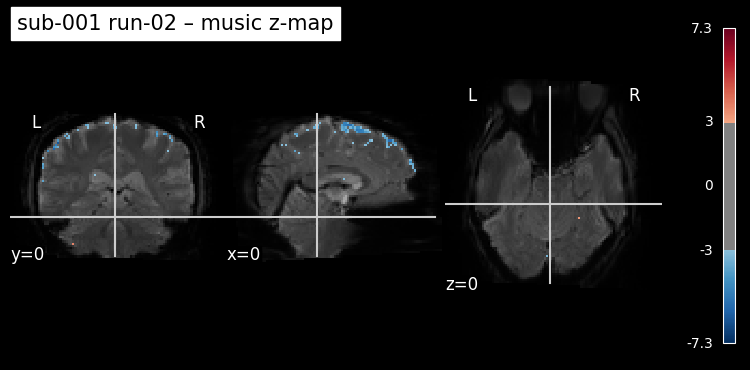

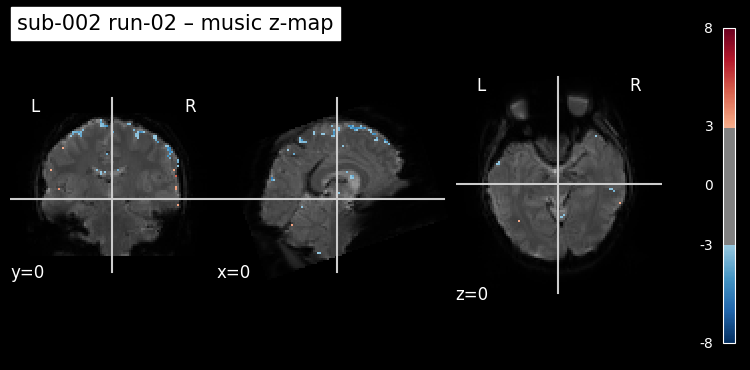

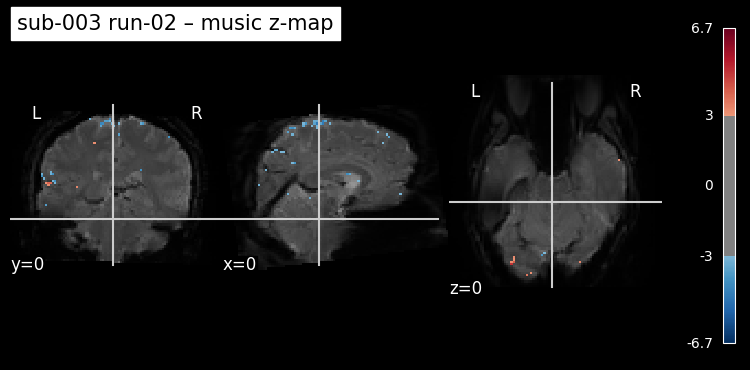

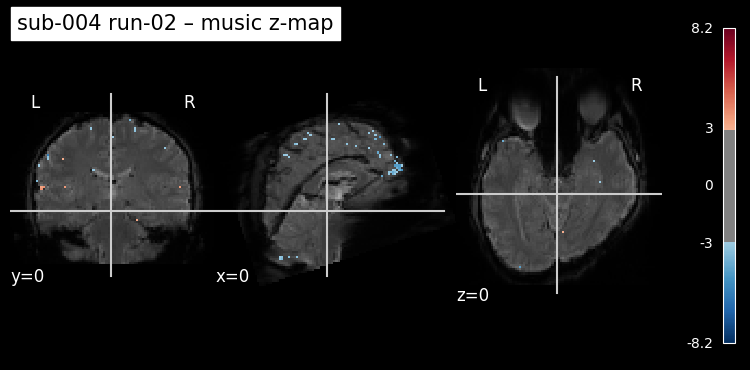

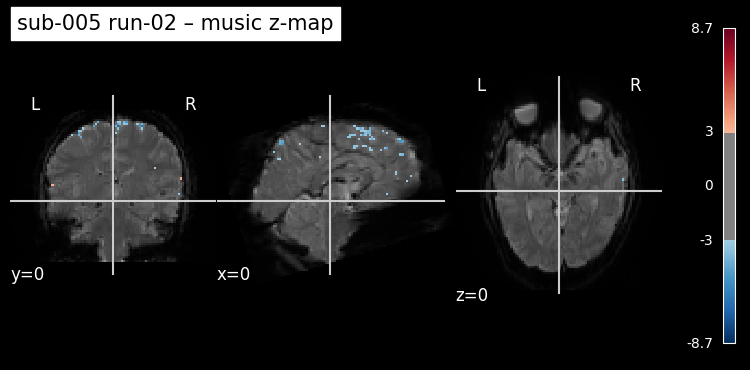

In [13]:
# Cell 7 – quick visualization of music z-map for all subjects

for sub_plot in SUBJECTS:
    print(f"Plotting {sub_plot} ...")

    # Get this subject's paths (run-02)
    paths_plot = get_subject_paths(sub_plot, run=2)

    # Path to this subject's z-map
    z_map_path = DERIV_ROOT / "firstlevel" / f"{sub_plot}_run-02_music_zmap.nii.gz"
    if not z_map_path.exists():
        print(f"  [WARN] z-map not found at {z_map_path}")
        continue

    # Load z-map and mean EPI
    z_map    = image.load_img(z_map_path)
    mean_epi = image.mean_img(paths_plot["bold"])

    # Create and display the figure
    disp = plotting.plot_stat_map(
        z_map,
        bg_img=mean_epi,
        title=f"{sub_plot} run-02 – music z-map",
        threshold=3.0,
        display_mode="ortho",
        cut_coords=(0, 0, 0),
    )
    display(disp)

# make sure all figures are flushed
plotting.show()